<a href="https://colab.research.google.com/github/Mateus-Silva98/analise_rede_social/blob/main/Classifica%C3%A7%C3%A3o_Textos_do_Twitter_com_spaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de textos do Twitter com spaCy

# Etapa 1: Importação e instalação das bibliotecas

In [1]:
#!pip install spacy --upgrade # Retornando uma mais atual
#!pip uninstall spacy -y
!pip install -q spacy==2.2.3 #Atualizado: 02/05/2021 Obs: utilizar esta versão. # Setado a versão do colab 

In [2]:
import spacy
spacy.__version__

'2.2.3'

In [5]:
#!pip uninstall -m spacy download pt #_core_news_sm
!python3 -m spacy download pt #_core_news_sm

 #pt  As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the full pipeline package name 'pt_core_news_sm' instead.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.2 MB 1.4 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=129856e92f1ab2dbcea47309ad15bcd4b29d13d8909a6db7d800647329511bd0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9gl72k9a/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
  Attempting uninstall: pt-core-news-sm
    Found existing installation: pt-core-news-sm 3.4.0
    Uninstalling pt-core-news-sm-3.4.0:
      Successfully uninstalled pt-core-news-sm-3.4.0
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [6]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns #geração de gráficos
import numpy as np
import re #expressões regulares

# Etapa 2: Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

- Negative label: 0
- Positive label: 1

In [7]:
base_treinamento = pd.read_csv('/content/Train50.csv', delimiter=';') #lendo o arquivo

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
base_treinamento.shape

(50000, 5)

In [10]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [12]:
base_treinamento.tail() #os últimos registros

,id,tweet_text,tweet_date,sentiment,query_used
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


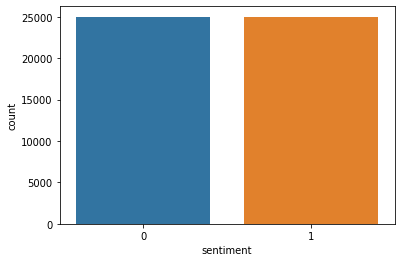

In [11]:
sns.countplot(base_treinamento['sentiment'], label = 'Contagem');

In [12]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [13]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


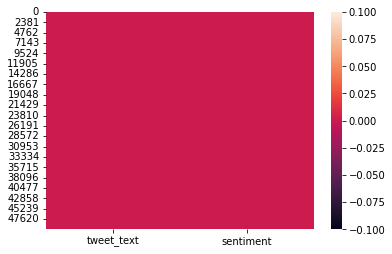

In [16]:
sns.heatmap(pd.isnull(base_treinamento));

## Base de teste

In [14]:
base_teste = pd.read_csv('/content/Test.csv', delimiter=';')

In [15]:
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [17]:
base_teste.shape

(5000, 5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


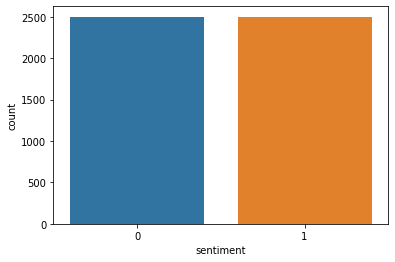

In [16]:
sns.countplot(base_teste['sentiment'], label='Contagem');

In [18]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [22]:
base_teste.head()

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


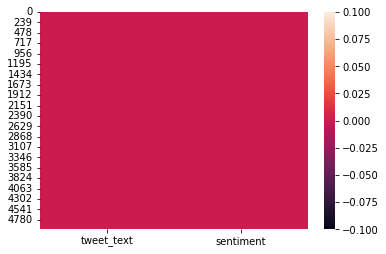

In [23]:
sns.heatmap(pd.isnull(base_teste)); #Checar se tem valor nulo

# Etapa 3: Função para pré-processamento dos textos - Tutorial da Função

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [19]:
pln = spacy.load('pt') #_core_news_sm #processamento de linguagem natural #Usando lib mais atual
pln

In [20]:
base_treinamento['tweet_text'][2]

'Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D'

In [21]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [22]:
print(stop_words) #Palavras que não dão sentido para a análise retirada no modelo

{'mas', 'ao', 'lugar', 'ponto', 'porquê', 'você', 'grandes', 'às', 'forma', 'sabe', 'ele', 'estar', 'da', 'quatro', 'aquela', 'estado', 'fazer', 'dá', 'nosso', 'próxima', 'mês', 'custa', 'aqui', 'nenhuma', 'pois', 'estás', 'quarta', 'poder', 'tivestes', 'tudo', 'pouca', 'sétima', 'querem', 'debaixo', 'és', 'portanto', 'à', 'falta', 'algo', 'pontos', 'veja', 'vinte', 'as', 'elas', 'dizer', 'disso', 'vem', 'ir', 'cento', 'deve', 'apenas', 'num', 'caminho', 'vossas', 'ali', 'em', 'sétimo', 'nossa', 'maiorias', 'por', 'estou', 'oito', 'parte', 'dezoito', 'sexto', 'comprido', 'do', 'toda', 'minha', 'vais', 'logo', 'pelos', 'pegar', 'mesmo', 'menor', 'seis', 'três', 'outra', 'novos', 'neste', 'estivestes', 'no', 'seu', 'des', 'tua', 'onde', 'contra', 'sete', 'todos', 'dez', 'fostes', 'numa', 'foi', 'aquelas', 'já', 'relação', 'baixo', 'nem', 'essas', 'uma', 'deste', 'teu', 'ver', 'suas', 'cima', 'tais', 'grande', 'põem', 'poderá', 'porque', 'primeiro', 'estive', 'vários', 'tu', 'faz', 'fazem

In [23]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
def preprocessamento(texto): #Criando a função
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto) #Para retirar o nome do usuário

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #"?" pode ou não aparecer a caractere anterior

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto) #Retirando dois ou mais espaços

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'} #Substituindo os valores
  for emocao in lista_emocoes: #Percorrer dentro do dataframe para substituir os valores
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematização
  documento = pln(texto)

  lista = [] 
  for token in documento: #Criando a separação das palavras o token
    lista.append(token.lemma_)
  
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation] #Retirando as pontuações e as palavras que não dão sentido na análise
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()]) #join para juntar as palavras com ' ', e retirando digitos
  
  return lista

In [25]:
texto_teste = '@tiavelhoca @creyto_ @broaordinaria @ClintPugstwood @bonitoporbosta @_malimallu @celsorodrigo_ @flcampagna @BrunoSuba Olar , tia :)'
resultado = preprocessamento(texto_teste) #passando a função de tratamento
resultado

'  olar tio emocaopositiva'

# Etapa 4: Pré-processamento da base de dados

### Limpeza dos textos

In [26]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
5,@KingJokerLeto mas amiga eu to aqui ainda :),1
6,"@RivasJairo Bravo, Jairo!!! :)))",1
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1
9,Amanha vou ver venom :D,1


In [27]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento) #aplicando na base de dados

In [40]:
base_treinamento.head(10)

,tweet_text,sentiment
0,pessoa certo vale azevedo emocaopositivo,1
1,precisamente contrário emocaopositivo vir ch...,1
2,video hoje ... pensar falar meta de o csgo pag...,1
3,aaaaaaaar ameir polaroids expressar to apaixon...,1
4,valorizar coração de o menininho elvc diferent...,1
5,amiga to emocaopositivo,1
6,Bravo jairo emocaopositivo,1
7,socorro ksoaksosks achar to em o caixinha so...,1
8,gostar fazenda emocaopositivo morro medo Gal...,1
9,amanha venom emocaopositivo,1


In [28]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento) #passando a funcao

In [30]:
base_teste.head(10)

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1
5,preciso emocaopositiva,1
6,acaso adorar beijo e abraço hahahahaha bue f...,1
7,solteiro s emocaopositiva,1
8,lindeza cortador kit mário coleção bia cravol ...,1
9,claro emocaopositiva,1


### Tratamento da classe

In [29]:
exemplo_base_dados = [["este trabalho é agradável", {"POSITIVO": True, "NEGATIVO": False}],
                      ["este lugar continua assustador", {"POSITIVO": False, "NEGATIVO": True}]]

In [31]:
base_dados_treinamento_final = [] #Tratando a base sobre o sentimento
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [32]:
len(base_dados_treinamento_final)

50000

In [33]:
base_dados_treinamento_final[10:15]

[['simplesmente o deixar chatear querer muitooo e iludir emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['o comedir umar rotina e perfeitamente parir consolidar o escola condução :p',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['amigar parecer apaixonar vc — recíproco emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['  gajar bacano aleijar esperar e o silvar feliz emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['tou o video cabra bebé emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}]]

In [34]:
base_dados_treinamento_final[45000:45005]

[['o menino pijama listrar o filmar triste mundo estruturar nenhum pra assistir rever e to pensar n emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['pra o vídeo luísa raiz o poliana infelizmente o twitter tá ruim amanhã postar emocaonegativa asaventurasdepoliana099',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['to crise abstinência strangers emocaonegativa — tbm :/ to',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['  esquecer olhar pra pagar o mensalidade turma pro cursar querer emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['querer comer doce comer montar hoje emocaonegativa maldição',
  {'NEGATIVO': True, 'POSITIVO': False}]]

# Etapa 5: Criação do classificador

In [35]:
modelo = spacy.blank('pt') #processamento de linguagem natural #Usando lib mais atual

In [40]:
categorias = modelo.create_pipe("textcat")

In [41]:
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")

1

In [58]:
#from thinc.api import Config
#from spacy.language import pt

In [42]:
modelo.add_pipe(categorias)
historico = []

ValueError: ignored

In [43]:
modelo.begin_training()
for epoca in range(20):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512): #retornando batchs
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses) #realiza a o processamento e atualização
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 3.475418611464942e-05}
{'textcat': 7.36796642031301e-08}
{'textcat': 5.7189362299633895e-09}
{'textcat': 2.164518305043661e-09}


In [44]:
historico_loss = [] #historico de valor do erro
for i in historico:
  historico_loss.append(i.get('textcat'))

In [45]:
historico_loss = np.array(historico_loss)
historico_loss

array([3.47541861e-05, 3.47541861e-05, 3.47541861e-05, ...,
       1.32873367e-09, 1.32873367e-09, 1.32873367e-09])

Text(0, 0.5, 'Erro')

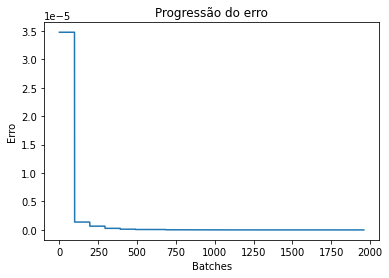

In [46]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [47]:
modelo.to_disk("modelo_classificador") #Gurdando o classificador gerado

# Etapa 6: Testes com uma frase

In [48]:
modelo_carregado = spacy.load('modelo_classificador')
modelo_carregado

## Texto positivo

In [49]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  ficar feliz q recíproco emocaopositiva'

In [50]:
previsao = modelo_carregado(texto_positivo)
previsao

  ficar feliz q recíproco emocaopositiva

In [51]:
previsao.cats #valores das categorias

{'NEGATIVO': 0.0002591503434814513, 'POSITIVO': 0.9999244213104248}

In [52]:
texto_positivo = 'eu gosto muito de você minha amiga'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gostar amigo'

In [53]:
modelo_carregado(texto_positivo).cats #Gerando o % do texto 

{'NEGATIVO': 0.852846086025238, 'POSITIVO': 0.15220032632350922}

## Texto negativo

In [54]:
base_teste['tweet_text'][4000]

'tô triste filmar mulan o mushu emocaonegativa'

In [55]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats #Valor maior para negativo e menor para positivo

{'NEGATIVO': 0.9998027682304382, 'POSITIVO': 0.0003306699509266764}

# Etapa 7: Avaliação do modelo

## Avaliação na base de treinamento


In [56]:
previsoes = []
for texto in base_treinamento['tweet_text']: #Passando o modelo na base de dados
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [57]:
previsoes #Listando todos os comentários dentro do seu % entre Positivo e Negativo

[{'NEGATIVO': 0.000379397562937811, 'POSITIVO': 0.9997337460517883},
 {'NEGATIVO': 0.00019170604355167598, 'POSITIVO': 0.9998573064804077},
 {'NEGATIVO': 0.00030546571360901, 'POSITIVO': 0.9995548129081726},
 {'NEGATIVO': 0.0005372315645217896, 'POSITIVO': 0.9995668530464172},
 {'NEGATIVO': 0.0003015337570104748, 'POSITIVO': 0.9996786117553711},
 {'NEGATIVO': 0.00044891025754623115, 'POSITIVO': 0.999167799949646},
 {'NEGATIVO': 0.0021024432498961687, 'POSITIVO': 0.9977376461029053},
 {'NEGATIVO': 0.0005383859970606863, 'POSITIVO': 0.9981787204742432},
 {'NEGATIVO': 0.0006178951589390635, 'POSITIVO': 0.9998534917831421},
 {'NEGATIVO': 0.0005171457887627184, 'POSITIVO': 0.9995517134666443},
 {'NEGATIVO': 0.0003492842079140246, 'POSITIVO': 0.9996906518936157},
 {'NEGATIVO': 0.0005920967669226229, 'POSITIVO': 0.9998435974121094},
 {'NEGATIVO': 0.00013307479093782604, 'POSITIVO': 0.9998464584350586},
 {'NEGATIVO': 0.00013703452714253217, 'POSITIVO': 0.9995686411857605},
 {'NEGATIVO': 0.0002

In [58]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']: #Setando valor 0 e 1 entre positivo e negativo
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [59]:
previsoes_final

array([1, 1, 1, ..., 0, 0, 0])

In [60]:
respostas_reais = base_treinamento['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final) # Deu 100 % de acuracidade

1.0

In [62]:
cm = confusion_matrix(respostas_reais, previsoes_final) # Todas corretas
cm

array([[25000,     0],
       [    0, 25000]])

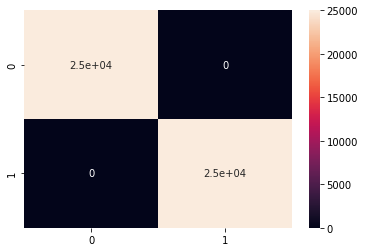

In [63]:
sns.heatmap(cm, annot=True) #errou nenhuma classificação nem na positiva e nem na negativa

## Avaliação na base de teste

In [64]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [65]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']: #Gerando a mesma trativa do teste anterior
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [66]:
respostas_reais = base_teste['sentiment'].values

In [67]:
accuracy_score(respostas_reais, previsoes_final) #Gerou uma acuracidade maior que a do curso

0.9974

In [68]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2493,    7],
       [   6, 2494]])

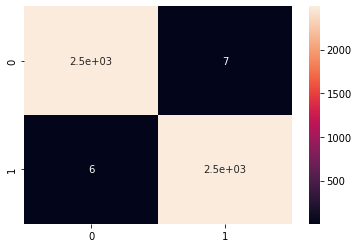

In [69]:
sns.heatmap(cm, annot=True) #Teve erros em positivos e negativos